In [1]:
import os
import numpy as np
import pickle


GLOVE_DIR = 'drive/MyDrive/Milestone2/glove.6B.100d.txt'
glove_dict = {}
with open(GLOVE_DIR) as f:
    for line in f:
        word, *vector = line.split()
        glove_dict[word]=np.array(vector).astype(float)

re_tokenized = pickle.load(open('drive/MyDrive/Milestone2/re_tokenized_lemma.pkl','rb'))

In [2]:
def get_average_glove_vec(list_of_tokens):
    avg_vec=[]
    for token in list_of_tokens:
    if token in glove_dict:
        avg_vec.append(glove_dict[token])

    if len(avg_vec)>0:
    avg_vec = np.mean(avg_vec, axis=0)
    else:
    avg_vec = np.zeros(100)

    return avg_vec

In [3]:
import pandas as pd
from tqdm import tqdm

df_original = pd.read_csv("drive/MyDrive/Milestone2/WikiLarge_Train.csv")
df_vecs = []

for ls in tqdm(re_tokenized):
    avg_vec = get_average_glove_vec(ls)
    df_vecs.append(avg_vec)

df_original['glove_avg'] = df_vecs

df = df_original.sample(100000, random_state=42)
X = df['glove_avg']
y = df['label']

100%|██████████| 416768/416768 [00:14<00:00, 28299.14it/s]


In [4]:
from sklearn.model_selection import train_test_split

Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,y,test_size=0.2, random_state=42)

In [5]:
# # save for later complex NN
# train_indexes = Train_X.index
# test_indexes = Test_X.index
Train_X = np.vstack(Train_X)
Test_X = np.vstack(Test_X)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(bootstrap= True,
 max_depth=70,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=800)

rf.fit(Train_X, Train_Y)
rf_preds = rf.predict(Test_X)
rf_acc = accuracy_score(Test_Y, rf_preds)
rf_f1 = f1_score(Test_Y, rf_preds)
rf_acc, rf_f1

(0.68005, 0.6875335709751452)

In [ ]:
pickle.dump(rf, open('drive/MyDrive/Milestone2/trained_models/rf_word2vec.pkl', 'wb'))

In [7]:
reloaded_rf = pickle.load(open('drive/MyDrive/Milestone2/trained_models/rf_word2vec.pkl', 'rb'))

In [8]:
from sklearn.metrics import accuracy_score, f1_score

rf_preds = reloaded_rf.predict(Test_X)
rf_acc = accuracy_score(Test_Y, rf_preds)*100
rf_f1 = f1_score(Test_Y, rf_preds)*100
rf_acc, rf_f1

(68.00500000000001, 68.75335709751452)

In [9]:
reloaded_rf.score(Train_X, Train_Y)

0.9695875

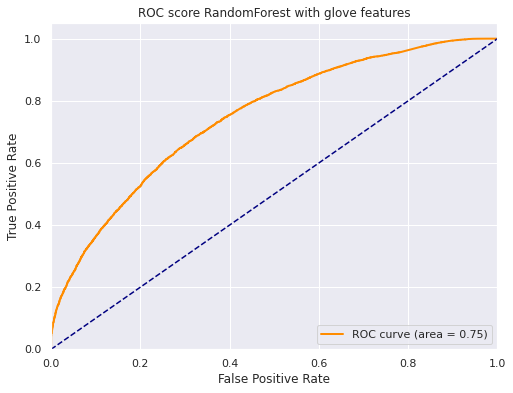

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_score = reloaded_rf.predict_proba(Test_X)
fpr, tpr, thresholds = roc_curve(Test_Y, y_score[:,1], pos_label=1)
area = auc(fpr, tpr)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score RandomForest with glove features')
plt.legend(loc="lower right")
plt.savefig('ROC_RandomForest_glove.jpg')

In [13]:
roc_df = pd.DataFrame([fpr, tpr,]).T
roc_df.columns = ['rf_fpr', 'rf_tpr']
roc_df['feat'] = 'glove'
roc_df.to_csv('roc_glove_100k.csv')

# Skipping SVM with large sample data

# MLP

### For Glove vectors do not need to do feature scaling

In [ ]:
from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import f1_score, accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(150), random_state=1, max_iter=300).fit(Train_X, Train_Y)
mlp_predict = mlp.predict(Test_X)
mlp_acc = accuracy_score(Test_Y, mlp_predict)
mlp_f1 = f1_score(Test_Y, mlp_predict)

In [ ]:
# pickle.dump(mlp, open('drive/MyDrive/Milestone2/trained_models/mlp_word2vec.pkl', 'wb'))

reloaded_mlp = pickle.load(open('drive/MyDrive/Milestone2/trained_models/mlp_word2vec.pkl', 'rb'))

In [ ]:
mlp_predict = reloaded_mlp.predict(Test_X)
mlp_acc = accuracy_score(Test_Y, mlp_predict)*100
mlp_f1 = f1_score(Test_Y, mlp_predict)*100
mlp_acc, mlp_f1

(64.05999999999999, 62.81043046357616)

In [ ]:
reloaded_mlp.score(Train_X, Train_Y)

0.7930125

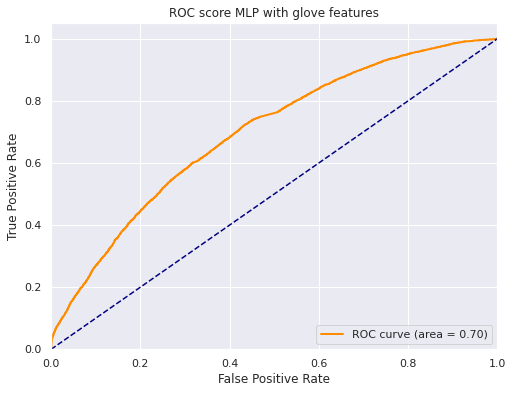

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_score = reloaded_mlp.predict_proba(Test_X)
fpr, tpr, thresholds = roc_curve(Test_Y, y_score[:,1], pos_label=1)
area = auc(fpr, tpr)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(8,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score MLP with glove features')
plt.legend(loc="lower right")
plt.savefig('ROC_MLP_glove.jpg')

# Summary

In [ ]:
score_df = pd.DataFrame([[mlp_acc, rf_acc],[mlp_f1, rf_f1]]).T
score_df.columns=['accuracy', 'f1 score']
score_df['model'] = ['MLP','RandomForest']
score_df.to_csv('scores_10w_glove.csv')

In [ ]:
score_df

,accuracy,f1 score,model
0,64.060,62.810430,MLP
1,68.005,68.753357,RandomForest
